In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import jax_cosmo as jc
import halox
import colossus.cosmology.cosmology as cc

jax.config.update("jax_enable_x64", True)


params = dict(
    Omega_c=0.2589,
    Omega_b=0.0486,
    h=0.6774,
    sigma8=0.8159,
    n_s=0.9667,
    Omega_k=0.0,
    w0=-1.0,
    wa=0.0,
)

hcosmo = jc.Cosmology(**params)

ccosmo = cc.setCosmology('mycosmo', {
    'Om0': params['Omega_c'] + params['Omega_b'],
    'Ob0': params['Omega_b'],
    'H0': params['h'] * 100,
    'sigma8': params['sigma8'],
    'ns': params['n_s'],
    'flat': True,
})

/Users/lamoreau/halox/.venv/lib/python3.11/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


In [2]:
import matplotlib.pyplot as plt

from halox.halo.cMrelation import (
    duffy08,
    prada12,
    klypin11,
    child18all,
    child18relaxed,
)

p18 = halox.cosmology.Planck18()

mray = jnp.logspace(11, 15, 20)
zray =jnp.linspace(0,2.25,9)

In [ ]:
def vectorize_model(model, mray, zray):
    return jax.vmap(lambda z: model(mray, z))(zray)


cduffy = vectorize_model(duffy08(), mray, zray) 
cprada = vectorize_model(prada12(p18), mray, zray)
ccall  = vectorize_model(child18all(p18), mray, zray)
ccrel  = vectorize_model(child18relaxed(p18), mray, zray)

x = (p18.Omega_m - 1)
# Below: Brian and Norman virial overdensity calculation
deltaBN = 18*jnp.pi**2 + 82 * x - 39 * x**2 
mklyp, rklyp, cklyp = \
    halox.halo.nfw.delta_delta(
        mray, 
        cduffy[0], 
        z=zray[0]*jnp.ones(len(mray)), 
        cosmo = p18, delta_old=200, delta_new=deltaBN
        )
cklypin = klypin11()(M=mklyp)

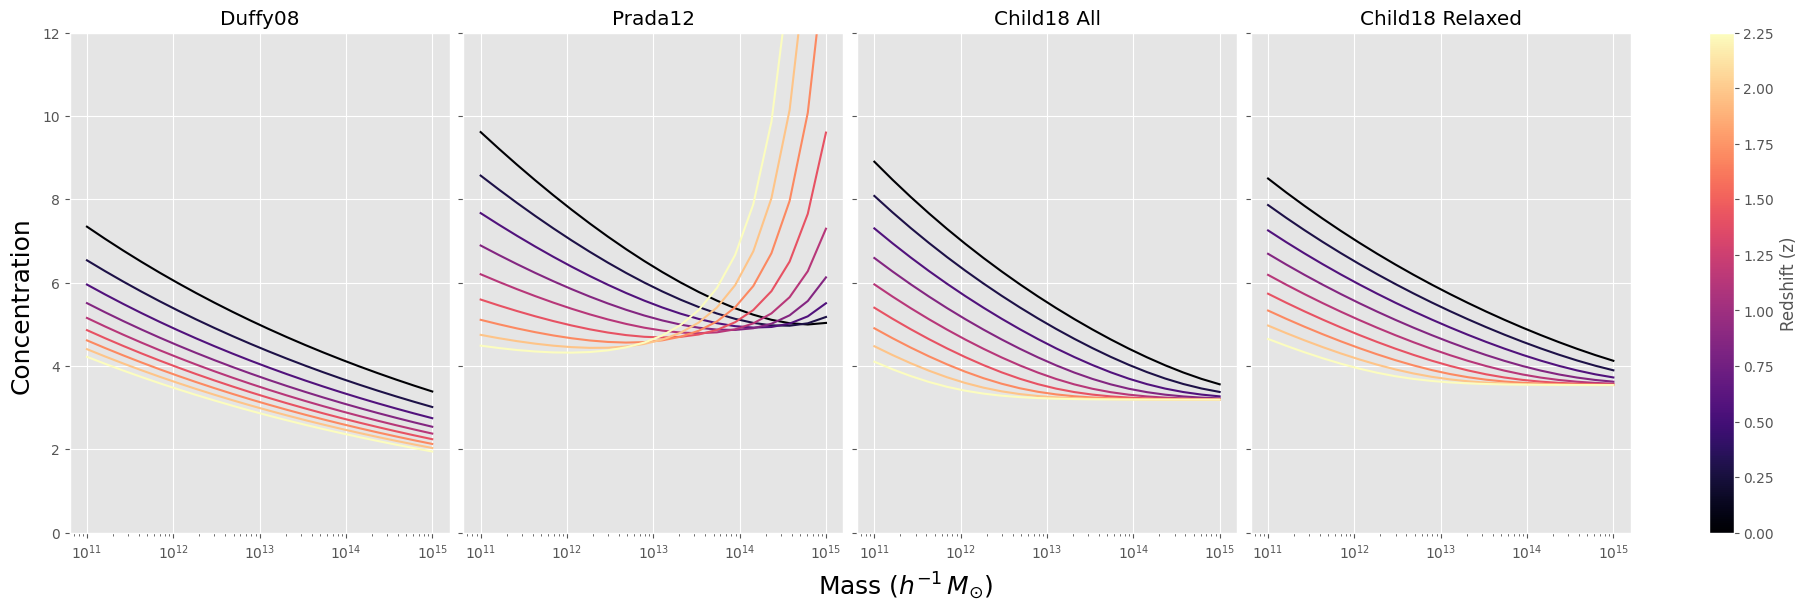

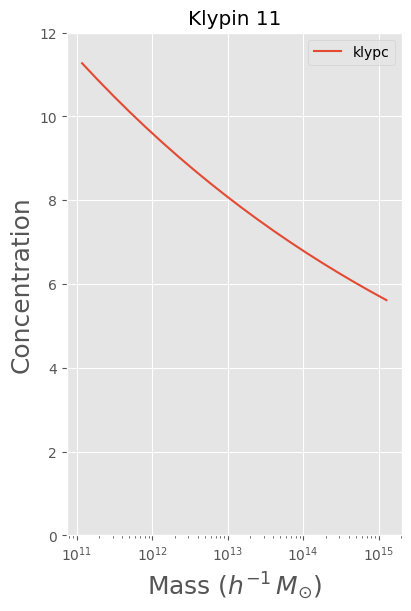

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

plt.style.use("ggplot")

models = [
    ("Duffy08", cduffy),
    ("Prada12", cprada),
    ("Child18 All", ccall),
    ("Child18 Relaxed", ccrel),
]

fig, axes = plt.subplots(
    1, 
    4, 
    figsize=(18, 6), 
    sharex=True, 
    sharey=True, 
    constrained_layout=True
    )

norm = mcolors.Normalize(vmin=zray.min(), vmax=zray.max())
cmap = cm.magma

for ax, (name, cvals) in zip(axes, models):
    
    for i, z in enumerate(zray):
        color = cmap(norm(z))
        ax.plot(
            mray,
            cvals[i],
            color = color
        )
    
    ax.set_xscale("log")
    ax.set_title(name)
    ax.set_ylim(0,12)

fig.supylabel("Concentration", fontsize = 18)
fig.supxlabel(r"Mass $(h^{-1}\,M_{\odot})$", fontsize = 18)
# Shared colorbar
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = fig.colorbar(sm, ax=axes.ravel().tolist())
cbar.set_label("Redshift (z)")

plt.show()

plt.figure(figsize=(4,6), constrained_layout = True)
plt.plot(mklyp, cklypin, label = "klypc")
# plt.plot(mklyp, cklyp, label = "duffyconvc")
plt.ylim(0,12)
plt.xscale("log")
plt.title("Klypin 11")
plt.ylabel("Concentration", fontsize = 18)
plt.xlabel(r"Mass $(h^{-1}\,M_{\odot})$", fontsize = 18)

plt.legend()
plt.show()


/Users/lamoreau/halox/.venv/lib/python3.11/site-packages/colossus/halo/concentration.py:442: UserWarning: Some masses or redshifts are outside the validity of the concentration model.
  warnings.warn('Some masses or redshifts are outside the validity of the concentration model.')


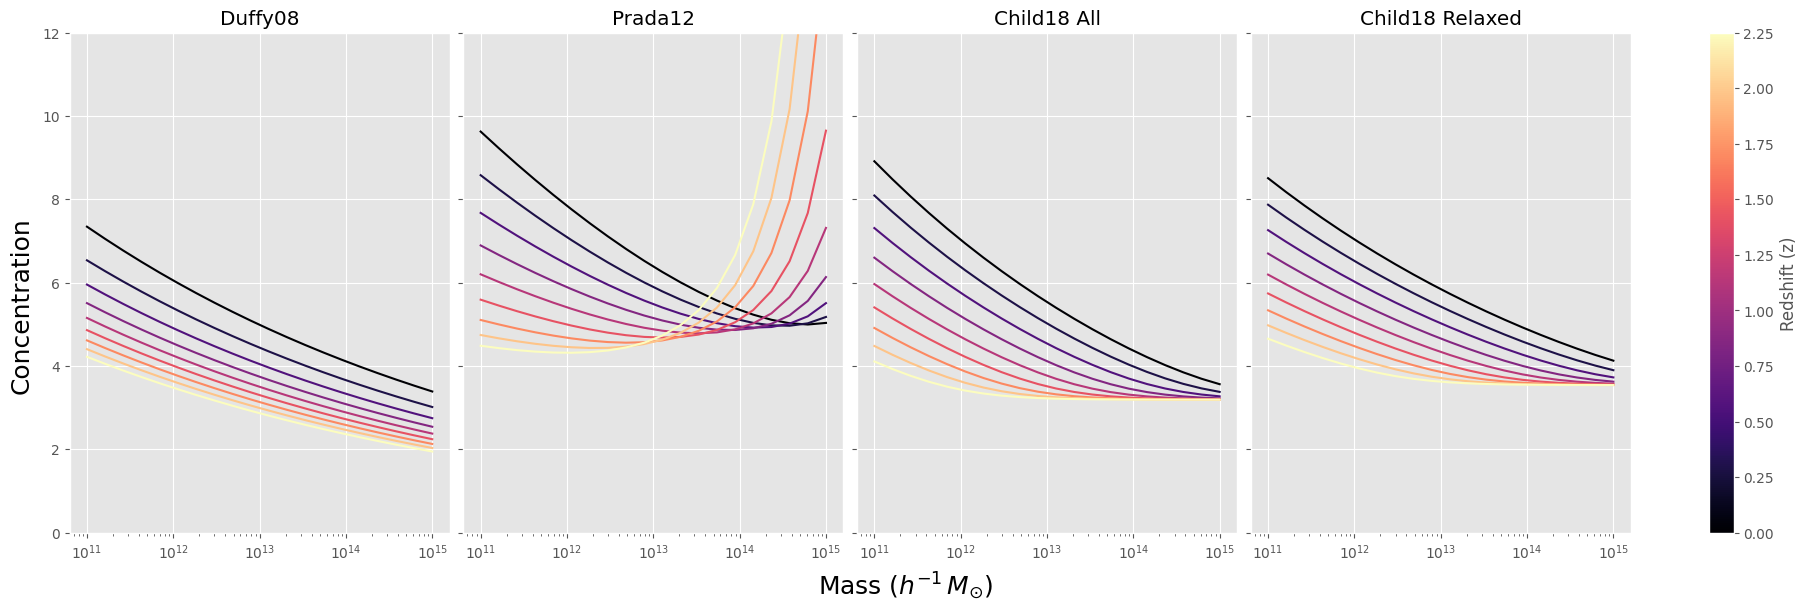

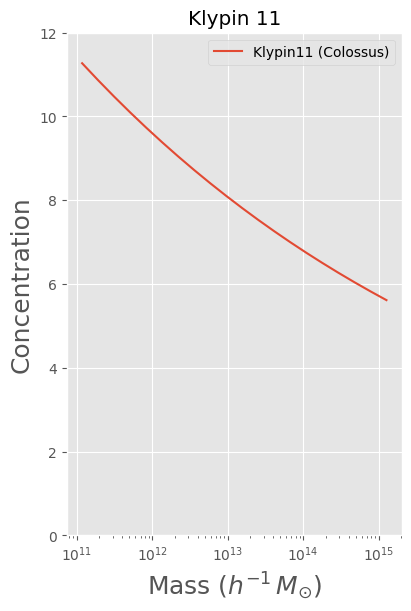

In [5]:
from colossus.cosmology import cosmology
from colossus.halo import concentration
from colossus.halo import mass_defs

# ------------------------------------------------------------------
# 1. Set cosmology (planck18, for consistency even though calibrated on WMAP7)
# ------------------------------------------------------------------

cosmo = cosmology.setCosmology('planck18')

# ------------------------------------------------------------------
# 2. Define grids (match your mray and zray)
# ------------------------------------------------------------------

mray_np = np.array(mray)
zray_np = np.array(zray)

# ------------------------------------------------------------------
# 3. Compute concentrations
# ------------------------------------------------------------------

cduffy_col = np.zeros((len(zray_np), len(mray_np)))
cprada_col = np.zeros_like(cduffy_col)
ccall_col  = np.zeros_like(cduffy_col)
ccrel_col  = np.zeros_like(cduffy_col)

for i, z in enumerate(zray_np):

    cduffy_col[i] = concentration.concentration(
        mray_np, '200c', z, model='duffy08'
    )

    cprada_col[i] = concentration.concentration(
        mray_np, '200c', z, model='prada12'
    )

    ccall_col[i] = concentration.concentration(
        mray_np, '200c', z, model='child18', halo_sample='individual_all'
    )

    ccrel_col[i] = concentration.concentration(
        mray_np, '200c', z, model='child18', halo_sample='individual_relaxed'
    )

# ------------------------------------------------------------------
# 4. Klypin conversion (match your delta conversion)
# ------------------------------------------------------------------

# Brian & Norman overdensity
x = cosmo.Om(0) - 1
deltaBN = 18*np.pi**2 + 82*x - 39*x**2

# Convert Duffy (z=0 slice like yours)
mklyp, rklyp, cklyp_conv = mass_defs.changeMassDefinition(
    mray_np,
    cduffy_col[0],
    zray_np[0],
    '200c',
    'vir'
)

cklypin_col = concentration.concentration(
    mklyp,
    'vir',
    zray_np[0],
    model='klypin11'
)

# ------------------------------------------------------------------
# 5. Plot — same layout as yours
# ------------------------------------------------------------------

plt.style.use("ggplot")

models = [
    ("Duffy08", cduffy_col),
    ("Prada12", cprada_col),
    ("Child18 All", ccall_col),
    ("Child18 Relaxed", ccrel_col),
]

fig, axes = plt.subplots(
    1, 4,
    figsize=(18, 6),
    sharex=True,
    sharey=True,
    constrained_layout=True
)

norm = mcolors.Normalize(vmin=zray_np.min(), vmax=zray_np.max())
cmap = cm.magma

for ax, (name, cvals) in zip(axes, models):

    for i, z in enumerate(zray_np):
        ax.plot(
            mray_np,
            cvals[i],
            color=cmap(norm(z))
        )

    ax.set_xscale("log")
    ax.set_ylim(0, 12)
    ax.set_title(name)

fig.supylabel("Concentration", fontsize=18)
fig.supxlabel(r"Mass $(h^{-1}\,M_{\odot})$", fontsize=18)

sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = fig.colorbar(sm, ax=axes)
cbar.set_label("Redshift (z)")

plt.show()

# ------------------------------------------------------------------
# 6. Klypin comparison panel
# ------------------------------------------------------------------

plt.figure(figsize=(4, 6), constrained_layout=True)

plt.plot(mklyp, cklypin_col, label="Klypin11 (Colossus)")
# plt.plot(mklyp, cklyp_conv, label="Duffy→vir converted")

plt.ylim(0, 12)
plt.xscale("log")

plt.title("Klypin 11")
plt.ylabel("Concentration", fontsize=18)
plt.xlabel(r"Mass $(h^{-1}\,M_{\odot})$", fontsize=18)
plt.legend()

plt.show()